In [97]:
import matplotlib.pyplot as plt
import numpy as np
import csv
import random

from BSE import market_session

Geometric browninan motion 

In [98]:
import random
import numpy as np
import matplotlib.pyplot as plt
import csv

# Define constants (adjust as needed)
bse_sys_minprice = 100
bse_sys_maxprice = 5000

# Geometric Brownian Motion Price Simulation
def simulate_price_path(initial_price, drift, volatility, time_steps, dt=1):
    """
    Simulates a price path using Geometric Brownian Motion.

    Parameters:
    - initial_price: Starting price.
    - drift: Expected return rate (e.g., 0.001 for 0.1%).
    - volatility: Volatility factor (e.g., standard deviation of returns).
    - time_steps: Number of steps to simulate.
    - dt: Time increment for each step (default is 1).

    Returns:
    - List of simulated prices over time.
    """
    prices = [initial_price]
    for _ in range(time_steps):
        shock = np.random.normal(0, 1)
        next_price = prices[-1] * np.exp((drift - 0.5 * volatility ** 2) * dt + volatility * shock * np.sqrt(dt))
        next_price = max(bse_sys_minprice, min(bse_sys_maxprice, next_price))  # Clamp to min/max price
        prices.append(next_price)
    return prices


In [99]:
def create_volatile_schedule(base_range, volatility_factor, start_time, end_time):
    """
    Generates a schedule with volatility applied to the price range.
    """
    schedule = []
    current_time = start_time
    while current_time < end_time:
        range_min = base_range[0] + random.randint(-volatility_factor, volatility_factor)
        range_max = base_range[1] + random.randint(-volatility_factor, volatility_factor)
        current_range = (max(bse_sys_minprice, range_min), min(bse_sys_maxprice, range_max))
        next_time = current_time + random.randint(10, 50)  # Random time increment
        schedule.append({'from': current_time, 'to': next_time, 'ranges': [current_range], 'stepmode': 'fixed'})
        current_time = next_time
    return schedule


In [100]:
def market_session(trial_id, start_time, end_time, traders_spec, order_sched, dump_flags, verbose=False):
    """
    Simulates a market session and writes GBM-generated prices to a CSV file.
    """
    prices_fname = trial_id + '_tape.csv'
    time_steps = (end_time - start_time) // 10  # Assuming fixed 10-unit intervals
    initial_price = 500  # Starting price, adjustable as needed
    drift = 0.0005  # Example drift factor
    volatility = 0.02  # Example volatility factor

    # Generate price path using GBM
    price_path = simulate_price_path(initial_price, drift, volatility, time_steps)

    # Write price path to file
    with open(prices_fname, 'w', newline='') as csvfile:
        writer = csv.writer(csvfile)
        for i, price in enumerate(price_path):
            writer.writerow([trial_id, start_time + i * 10, price])  # Increment time by 10 units


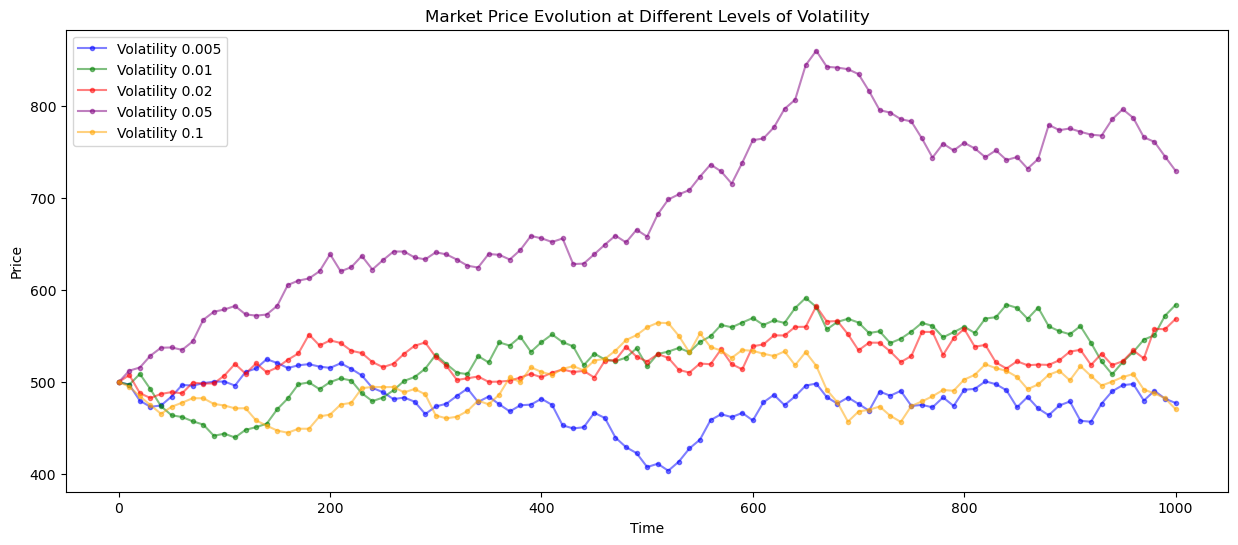

In [101]:
# Plotting multiple volatility levels
volatility_levels = [0.005, 0.01, 0.02, 0.05, 0.1]  # Different levels of volatility (in GBM terms)
colors = ['blue', 'green', 'red', 'purple', 'orange']

plt.figure(figsize=(15, 6))

for volatility_factor, color in zip(volatility_levels, colors):
    # Generate schedules (unchanged)
    supply_schedule = create_volatile_schedule((300, 400), int(volatility_factor * 100), 0, 1000)
    demand_schedule = create_volatile_schedule((300, 400), int(volatility_factor * 100), 0, 1000)

    sellers_spec = [('ZIP', 100), ('ZIC', 10), ('SHVR', 10), ('GVWY', 10)]
    buyers_spec = sellers_spec
    traders_spec = {'sellers': sellers_spec, 'buyers': buyers_spec}

    order_interval = 1
    order_sched = {'sup': supply_schedule, 'dem': demand_schedule,
                   'interval': order_interval, 'timemode': 'drip-poisson'}

    n_sessions = 1
    x = np.empty(0)
    y = np.empty(0)

    for sess in range(n_sessions):
        trial_id = f'smith_chart_vol_{int(volatility_factor * 100)}_' + str(sess)

        # Simulate market session with GBM
        market_session(trial_id, 0, 1000, traders_spec, order_sched, None, verbose=False)

        # Read price data from the generated CSV
        prices_fname = trial_id + '_tape.csv'
        with open(prices_fname, newline='') as csvfile:
            reader = csv.reader(csvfile)
            for row in reader:
                time = float(row[1])
                price = float(row[2])
                x = np.append(x, time)
                y = np.append(y, price)

    # Plot the results
    plt.plot(x, y, '.', color=color, alpha=0.5, label=f'Volatility {volatility_factor}', linestyle='-')

plt.xlabel('Time')
plt.ylabel('Price')
plt.title('Market Price Evolution at Different Levels of Volatility')
plt.legend()
plt.show()


Stochastic volatility 

In [102]:
def heston_simulation(S0, v0, mu, kappa, theta, xi, rho, T, N, paths):
    """
    Simulates price paths using the Heston model.

    Parameters:
    - S0: Initial asset price.
    - v0: Initial variance.
    - mu: Drift (expected return).
    - kappa: Rate of mean reversion for variance.
    - theta: Long-term variance mean.
    - xi: Volatility of variance (vol of vol).
    - rho: Correlation between price and variance.
    - T: Time to maturity.
    - N: Number of time steps.
    - paths: Number of simulation paths.

    Returns:
    - S: Simulated price paths (array of shape (paths, N+1)).
    - v: Simulated variance paths (array of shape (paths, N+1)).
    """
    dt = T / N  # Time step
    S = np.zeros((paths, N + 1))  # Price paths
    v = np.zeros((paths, N + 1))  # Variance paths

    S[:, 0] = S0
    v[:, 0] = v0

    for t in range(1, N + 1):
        # Generate two correlated random normal variables
        z1 = np.random.normal(size=paths)
        z2 = np.random.normal(size=paths)
        W1 = z1
        W2 = rho * z1 + np.sqrt(1 - rho**2) * z2

        # Variance process (CIR)
        v[:, t] = np.maximum(
            v[:, t - 1] + kappa * (theta - v[:, t - 1]) * dt + xi * np.sqrt(v[:, t - 1]) * np.sqrt(dt) * W2,
            0  # Ensure variance remains non-negative
        )

        # Price process
        S[:, t] = S[:, t - 1] * np.exp(
            (mu - 0.5 * v[:, t - 1]) * dt + np.sqrt(v[:, t - 1]) * np.sqrt(dt) * W1
        )

    return S, v


In [103]:
# Heston Model Parameters
S0 = 400          # Initial price
v0 = 0.04         # Initial variance
mu = 0.05         # Drift (5% annualized return)
kappa = 2.0       # Rate of mean reversion
theta = 0.04      # Long-term mean variance (4%)
xi = 0.1          # Volatility of variance (vol of vol)
rho = -0.7        # Correlation between price and variance
T = 1.0           # Time horizon (1 year)
N = 100           # Number of intervals
paths = 1         # Single path for schedule generation




In [104]:
start_time = 0
end_time = 60 * 10
order_interval = 10
chart1_range=(80, 320)

In [105]:
# Simulate Heston price paths
supply_prices, supply_variances = heston_simulation(S0, v0, mu, kappa, theta, xi, rho, T, N, paths)
demand_prices, demand_variances = heston_simulation(S0, v0, mu, kappa, theta, xi, rho, T, N, paths)

In [106]:
# Create schedules
supply_schedule = []
demand_schedule = []

current_time = start_time
time_step = (end_time - start_time) / N

for i in range(N):
    next_time = current_time + time_step
    # Define price ranges based on simulated prices
    supply_range = (max(bse_sys_minprice, supply_prices[0, i] - 10), 
                    min(bse_sys_maxprice, supply_prices[0, i] + 10))
    demand_range = (max(bse_sys_minprice, demand_prices[0, i] - 10), 
                    min(bse_sys_maxprice, demand_prices[0, i] + 10))

    # Append to schedules
    supply_schedule.append({'from': current_time, 'to': next_time, 'ranges': [supply_range], 'stepmode': 'random'})
    demand_schedule.append({'from': current_time, 'to': next_time, 'ranges': [demand_range], 'stepmode': 'random'})

    current_time = next_time


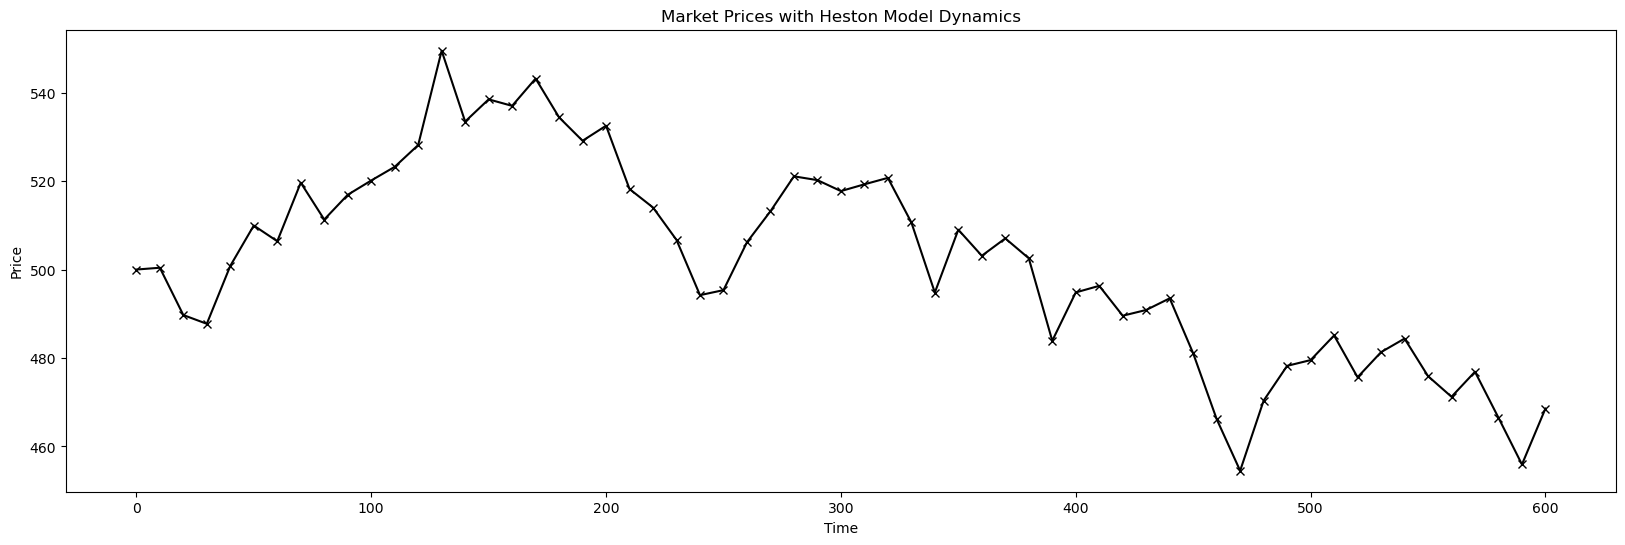

In [107]:
order_schedule = {'sup': supply_schedule, 'dem': demand_schedule, 'interval': order_interval, 'timemode': 'drip-poisson'}
sellers_spec = [ ('GVWY', 40)]
#sellers_spec = [ ('ZIC', 20)]
buyers_spec = [('AgentPlus', 20), ('ZIC', 20)]
#buyers_spec = [('ZIP', 20)]

traders_spec = {'sellers':sellers_spec, 'buyers':buyers_spec}

# Directly run the market session with the Heston-based schedules
verbose = False

dump_flags = {
    'dump_blotters': True,
    'dump_lobs': True,
    'dump_strats': True,
    'dump_avgbals': True,
    'dump_tape': True
}

n_sessions = 1

x = np.empty(0)
y = np.empty(0)

for sess in range(n_sessions):
    trial_id = 'heston_model_chart_' + str(sess)

    # Directly run the market session
    market_session(trial_id, start_time, end_time, traders_spec, order_schedule, dump_flags, verbose)

    # Read prices from the generated tape
    prices_fname = trial_id + '_tape.csv'
    with open(prices_fname, newline='') as csvfile:
        reader = csv.reader(csvfile)
        for row in reader:
            time = float(row[1])
            price = float(row[2])
            x = np.append(x, time)
            y = np.append(y, price)

# Plot the results
plt.figure(figsize=(20, 6))
plt.plot(x, y, 'x', color='black', linestyle = '-')
plt.title('Market Prices with Heston Model Dynamics')
plt.xlabel('Time')
plt.ylabel('Price')
plt.show()
